In [1]:
%matplotlib inline

# Création de données synthétiques

In [2]:
import pointprocesses as ppr
import itertools
import numpy as np
import matplotlib.pyplot as plt

Le processus de Hawkes à noyau exponentiel est modélisé par
$$
    g(t) = \alpha\beta e^{-\beta t}
$$

In [3]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [4]:
T = 60.0
alpha = 0.2
beta  = 0.5
lam0  = 1.0

In [5]:
print("Avg. no. of events: %.3f" % (T*lam0/(1-alpha)))

Avg. no. of events: 75.000


77


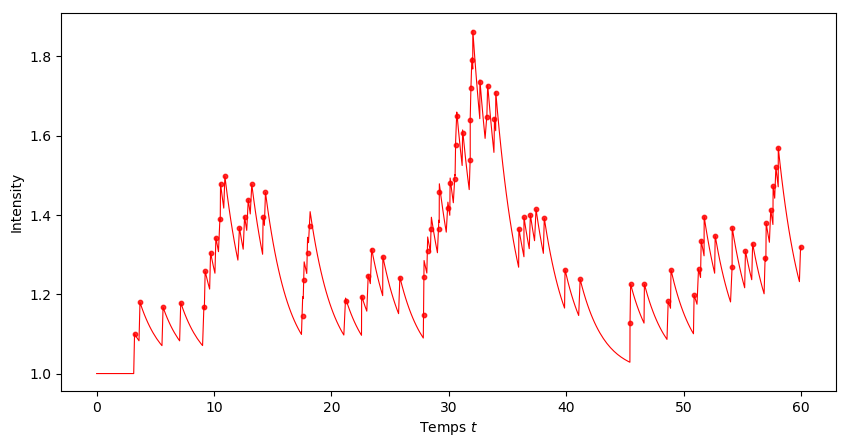

In [6]:
data = ppr.hawkes_exp(T, beta, lam0, itertools.repeat(alpha))
print(data[:,0].size)

time_vals = np.sort(np.append(np.linspace(0, T, 400), data[:,0]))

ints_proc = intensity_function(time_vals, lam0, alpha, beta, data[:,0])

fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel("Intensity")
ax.scatter(data[:,0], data[:,1], c='r', s=10, alpha=0.8)
ax.plot(time_vals, ints_proc, 'r-', linewidth=0.8)

# Network design

On utilisera PyTorch pour réaliser notre réseau de neurones récursif (RNN).

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as tnf

In [8]:
x = torch.rand(5, 3)

In [ ]:
torch.

In [9]:
print(x)

tensor([[0.5625, 0.5942, 0.5196],
        [0.2528, 0.7382, 0.6108],
        [0.4734, 0.7224, 0.2923],
        [0.3849, 0.3814, 0.9099],
        [0.0176, 0.1753, 0.4737]])


### Basic RNN

Algorithme d'Ogata pour le calcul récursif de la fonction d'intensité $\lambda$:
$$
    \lambda_k = \lambda_0 + e^{-\beta(t_k-t_{k-1})}(\lambda_{k-1} - \lambda_0) + \alpha\beta \xi_k
$$
où $\xi_k = \xi(t_k)$ vaut 1 ssi il s'est produit un événement en $t_k$ et 0 sinon.

La probabilité qu'un événement se produise entre $t_{k-1}$ et $\Delta t$:
$$
    \mathbb P(t_k\in[t_{k-1}, t_{k-1} + \Delta t], \xi_k = 1\mid \mathcal H_{k-1}) = 1 - \exp\left(-(\lambda_{k-1} - \lambda_0)\left(\frac{1 - e^{-\beta\Delta t}}{\beta}\right) - \lambda_0\Delta t\right) := \mathcal L_k(\Delta t)
$$

En effet, $t_k$ suit conditionnellement une loi exponentielle de paramètre
$$
    \Lambda = \int_{t_{k-1}}^{t_k} \lambda_s\,\mathrm ds.
$$
et on peut utiliser la formule d'Ogata (qui est exacte) pour exprimer $\lambda_s$, le terme en $\xi(s)$ étant d'intégrale nulle.

On cherche le meilleur estimateur $\beta \in \{\beta_1,\ldots,\beta_p\}$ parmi des valeurs discrètes.

On peut utiliser un algorithme d'_inférence bayésienne_:
$$
    \mathbb P(\beta_j\mid \mathcal H_k) \sim \sum_{\xi_k\in\{0,1\}}\mathbb P(\xi_k, t_k\mid \mathcal H_{k-1},\beta_j) \mathbb P(\beta_j\mid \mathcal H_{k-1})
$$
où 
$$
    \mathbb P(\xi_k, t_k\mid \mathcal H_{k-1},\beta_j) = \mathcal L_k^{(j)}(t_k - t_{k-1})\left(\lambda_0 + e^{-\beta_j(t_k - t_{k-1})}(\lambda_k^{(j)} - \lambda_0) \right)^{\xi_k}
$$
avec l'indice $(j)$ précisant que les valeurs sont calculées pour $\beta = \beta_j$.

In [10]:
x

tensor([[0.5625, 0.5942, 0.5196],
        [0.2528, 0.7382, 0.6108],
        [0.4734, 0.7224, 0.2923],
        [0.3849, 0.3814, 0.9099],
        [0.0176, 0.1753, 0.4737]])

In [11]:
x > 0.5

tensor([[1, 1, 1],
        [0, 1, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

In [12]:
torch.rand_like(x)

tensor([[0.5235, 0.2790, 0.2596],
        [0.6024, 0.9329, 0.4235],
        [0.7328, 0.2434, 0.1821],
        [0.7428, 0.7613, 0.9222],
        [0.3786, 0.8336, 0.4983]])

In [49]:
class RNN(nn.Module):
    """
    This recurrent neural network will learn the decay parameter of
    a hawkes process and generate a sequence of events.
    """
    def __init__(self, input_size, hidden_size, output_size, mu, alpha, betas, p_betas):
        """
        betas (array): candidate values for the beta parameter
        p_betas (array): prior probability distribution of the beta values
        """
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.mu = mu
        self.alpha = alpha
        self.betas = betas
        self.beta_priors = p_betas
        self.beta_posts = p_betas
        self.event_x = torch.zeros(input_size)
        self.intens = torch.emp
        
        self.fch = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, events: torch.Tensor, hidden: torch.Tensor):
        concat = torch.cat((events, hidden), 0)
        print("Updating hidden layer...")
        hidden = self.fch(concat)
        # new times
        dt = -1.0/self.intens*torch.rand_like(events)
        output = events + dt
        maxlambda = self.intens.copy()
        self.intens = self.mu + \
            (-self.betas*(output-events)).exp()*(self.intens-self.mu) + \
            alpha*self.betas
        
        # check for new events happening
        u = torch.rand_like(events)
        self.event_x = self.intens*u/maxlambda
        print("New events happening:")
        print(self.event_x)
        self.intens += alpha*self.betas*self.event_x
        print("Updating posteriors...")
        self.beta_posts = self.likelihood(dt, self.event_x)
        print(self.beta_posts)
        print()
        return output, hidden
    
    def likelihood(self, dt, x):
        """
        Compute the likelihoods of the next event happening within dt.
        """
        exponent = (self.intens - self.mu)*(1 - (-self.betas*dt).exp())/betas + self.mu*dt
        l = 1 - (-exponent).exp()
        fact = self.mu + (-self.betas*dt).exp()*(self.intens - self.mu)
        return l*fact.pow(x)/self.beta_priors
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

On crée un échantillon synthétique de $M= 1000$ trajectoires.

In [50]:
T = 60.0
alpha = 0.4
beta = 0.3 # real beta value
betas = torch.Tensor(np.linspace(0.1, 0.6, 5))
lam0 = 1.0

betas = betas.view(-1,1)
print("Valeurs de beta à tester:")
print(betas)

print("Avg. no. of events: %.3f" % (T*lam0/(1-alpha)))

n_samples = 10
sample_data = [ppr.hawkes_exp(T, beta, lam0, itertools.repeat(alpha)) for _ in range(n_samples)]

Valeurs de beta à tester:
tensor([[0.1000],
        [0.2250],
        [0.3500],
        [0.4750],
        [0.6000]])
Avg. no. of events: 100.000


Les trajectoires simulées ont des longueurs différentes. On les prolonge suffisament et on les rassemble dans un tenseur.

In [51]:
input_size = max(s.shape[0] for s in sample_data)
print(input_size)

arr = np.dstack([np.pad(a, ((input_size - a.shape[0],0),(0,0)), 'constant') for a in sample_data])
data_tensor = torch.from_numpy(arr)
print(data_tensor.shape)

113
torch.Size([113, 3, 10])


In [52]:
p_betas = torch.ones_like(betas)/betas.shape[0]
print("Distribution of beta priors:")
print(p_betas)

Distribution of beta priors:
tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000]])


In [53]:
net = RNN(n_samples, 10, n_samples, lam0, alpha, betas, p_betas)

net

AttributeError: module 'torch' has no attribute 'emp'

### Loss function

On wrappe la fonction `pointprocesses.likelihood.hawkes_likelihood` de notre librairie pour interagir avec PyTorch:

In [32]:
def _hawkes_likelihood_tensor(input: torch.Tensor, decay):
    """
    Args:
    input (Tensor): event data
    """
    mu = lam0
    tmax = T
    return -ppr.likelihood.hawkes_likelihood(input.numpy(), mu, alpha, decay, tmax)

In [33]:
train_examples = data_tensor[:,0,:]
train_examples.dtype
print(train_examples.shape)

torch.Size([150, 1000])


In [34]:
ppr.likelihood.hawkes_likelihood?

Docstring:
Compute the log-likelihood of the given data under a Hawkes
model with the supplied parameters.

Args:
    times (array): data event arrival times.
    mu (float): background rate.
    alpha (float): jump parameter.
    decay (float): decay parameter
    tmax (float): temporal horizon.
Type:      builtin_function_or_method


In [35]:
train_examples.shape

torch.Size([150, 1000])

In [36]:
train_examples[:,0]

tensor([ 0.9432,  0.9450,  2.4557,  3.1930,  3.3054,  3.8113,  4.2473,  4.4562,
         4.5994,  4.7346,  5.3160,  5.7228,  6.0870,  6.3748,  6.3979,  6.9107,
         7.3747,  7.5027,  7.6883,  7.8549,  8.5101,  8.5959,  9.0937,  9.2324,
         9.3074,  9.3135,  9.3253,  9.4410,  9.9566, 10.6317, 10.9151, 12.6330,
        13.2012, 13.7555, 13.8485, 13.9894, 15.3950, 16.0855, 16.5800, 17.2135,
        18.7533, 19.0078, 20.1930, 20.8595, 21.9107, 24.1944, 24.8034, 28.1627,
        28.2342, 28.5741, 30.4926, 31.0944, 31.1824, 31.9308, 33.3545, 33.3794,
        33.5315, 34.0158, 34.4052, 34.9440, 35.0421, 36.0038, 36.3002, 36.3163,
        38.3783, 38.8893, 39.9398, 40.2488, 40.7382, 44.0230, 44.7724, 44.8522,
        46.3850, 47.4883, 47.9344, 48.1363, 48.3135, 49.0132, 49.4326, 50.0511,
        52.2235, 53.7217, 54.3949, 54.6011, 55.5961, 55.8609, 57.5204, 57.8024,
        58.1451, 59.1466,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [37]:
_hawkes_likelihood_tensor(train_examples[:,0], beta)

43.08111324902771

In [46]:
train_examples.shape

torch.Size([150, 1000])

In [47]:
learn_rate = 0.005

def train(data_tensor, n_samples=1000, n_epochs=10):
    hidden = net.initHidden()
    generated_sequence = []
    net.zero_grad()
    
    for i in range(data_tensor.size(0)):
        print("Step %d" % i)
        output, hidden = net(data_tensor[:,i], hidden)
        generated_sequence.append(output)
    
    return generated_sequence

In [48]:
train(train_examples)

Step 0


RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)